In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%config IPCompleter.use_jedi = False

In [193]:
import numpy as np
from scipy.ndimage import label, distance_transform_edt
from skimage import io, img_as_float, filters, morphology, transform, draw
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.morphology import watershed
#from L4.image_util import *
import pandas as pd
import glob

In [57]:
img_dir = r'G:\My Drive\ForLuke\Luke Focus Images 20210430'
df = None
for file in glob.glob(img_dir+"\*.tif*"):
    names = file.split('\\')[-1].split(' ')
    data = {x.split('_')[0]:[x.split('_')[1].strip('.tif')] for x in names[1:]}
    data['file']=file
    df_new = pd.DataFrame(data )
    if df is None:
        df = df_new
    else:
        df = pd.concat((df, df_new))
        
df['']=df[''].astype(int)
df['center']=df['center'].astype(int)

In [116]:
gb = df.groupby(by=['x', 'y'])

def get_best(v, focus=True):
    c = v['center'].values[0]
    global insp
    if focus:
        index = np.argmin(np.abs(np.subtract(v[''].values,c)))
    else:
        index=1
    insp = v, index
    return v.iloc[index]
df_res = gb.apply(get_best)
files = df_res['file'].values
df_unfocus = gb.apply(get_best, False)
unfocus = df_unfocus['file'].values
imgs = [img_as_float(io.imread(x)) for x in unfocus]

In [184]:
idx= 0
img = io.imread(files[idx])

In [189]:
def get_labels(img):
    image = img.copy()
    # Make sure types are the same
    input_image = img_as_float(image)
    input_image = input_image 
    # Subtract background
    signal_image = input_image# - background

    #Resize for faster analysis
    signal_image = transform.rescale(signal_image, 0.5)

    # Normalize between 0 and 1
    normalized_image = (signal_image - signal_image.min()) / (signal_image.max() - signal_image.min())
    # Filter Image
    filtered_image = filters.median(normalized_image, behavior='ndimage')
    # Edge Detection
    edge_sobel = filters.sobel(filtered_image)

    # Threshold
    thresh = filters.threshold_otsu(edge_sobel)
    binary_otsu = edge_sobel > thresh

    # Binary Morphology Operations
    structure_element = morphology.disk(5)

    closed_image = morphology.binary_closing(binary_otsu, structure_element)
    filled = morphology.remove_small_holes(closed_image, area_threshold=200)
    opened = morphology.remove_small_objects(filled, min_size=50)
    structure_element = morphology.disk(20)
    closed_image = morphology.binary_closing(opened, structure_element)
    structure_element = morphology.disk(20)
    opened_image = morphology.binary_opening(closed_image, structure_element)
    
    # Watershed
    distance = distance_transform_edt(opened_image)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((50,50)), labels=opened_image)
    markers = label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=opened_image)
    
    #Regions
    properties = ['centroid', 'area', 'eccentricity', 'convex_area', 'equivalent_diameter']
    regions = regionprops_table(labels,properties=properties)
    regions = pd.DataFrame(regions)
    
    return regions, labels
regions, labels = get_labels(img)

In [325]:
class ImageDetect:
    
    def __init__(self, img):
        self.img = img.copy()
        self.img_display = None
        self.regions=None
        self.labels=None
        self.row = None
        self.create_blank_display()
        self.signal_image = None
        self.normalized_image = None
        self.filtered_image = None
        self.edge_sobel = None
        self.binary_otsu = None
        self.closed_image1 = None
        self.filled = None
        self.opened = None
        self.closed_image2 = None
        self.labels = None
        self.opened2 = None
        
    
    def get_regions(self):
        image = self.img
        # Make sure types are the same
        input_image = img_as_float(image)
        input_image = input_image 
        # Subtract background
        signal_image = input_image# - background

        #Resize for faster analysis
        signal_image = transform.rescale(signal_image, 0.5)

        # Normalize between 0 and 1
        self.normalized_image = normalized_image = (signal_image - signal_image.min()) / (signal_image.max() - signal_image.min())
        # Filter Image
        self.filtered_image = filtered_image = filters.median(normalized_image, behavior='ndimage')
        # Edge Detection
        self.edge_sobel = edge_sobel = filters.sobel(filtered_image)

        # Threshold
        thresh = filters.threshold_otsu(edge_sobel)
        self.binary_otsu = binary_otsu = edge_sobel > thresh

        # Binary Morphology Operations
        structure_element = morphology.disk(5)

        self.closed_image1 = closed_image = morphology.binary_closing(binary_otsu, structure_element)
        self.filled = filled = morphology.remove_small_holes(closed_image, area_threshold=200)
        self.opened = opened = morphology.remove_small_objects(filled, min_size=50)
        structure_element = morphology.disk(20)
        self.closed_image2 = closed_image = morphology.binary_closing(opened, structure_element)
        structure_element = morphology.disk(20)
        self.opened2 = opened_image = morphology.binary_opening(closed_image, structure_element)

        # Watershed
        distance = distance_transform_edt(opened_image)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((50,50)), labels=opened_image)
        markers = label(local_maxi)[0]
        self.labels = labels = watershed(-distance, markers, mask=opened_image)

        #Regions
        assert np.max(labels)-np.min(labels)>=1, "No Cells Detected, Move and Try again"
            
        properties = ['centroid', 'area', 'eccentricity', 'convex_area', 'equivalent_diameter']
        regions = regionprops_table(labels,properties=properties)
        self.regions = regions = pd.DataFrame(regions)
        self.labels = labels
        return regions
    
    def select_cell(self):
        regions = self.regions

        # Filter the regions by area
        regions=regions[regions['area']>10000]
        assert regions.shape[0]>1, "No Cells Detected, Move and Try again"

        # Get a random row from the regions
        row = regions.sample(1).iloc[0]
        self.row = row
        return row
    
    def create_blank_display(self):
        # Normalize the image
        img=self.img.copy()
        img_display = transform.rescale(img, 0.5)
        im_st = img_display - np.quantile(img_display,0.1)
        #Convert to color
        rggb = gray2rgb(im_st*1/(np.quantile(im_st,0.95)))
        self.img_display=rggb
        return rggb
    
    def draw_cell(self):
        img_display = self.img_display[:,:,0]
        rggb = self.img_display
        row = self.row
        
        # Display our detected images:
        # Draw a circle around the selected cell
        rr, cc = draw.circle_perimeter(int(row['centroid-0']), int(row['centroid-1']),
                              int(row['equivalent_diameter']/2), shape=img_display.shape)

        # Get the circle perimeter of the cell and make it bigger
        perim = np.zeros(img_display.shape)
        perim[rr,cc]=1
        perim = morphology.dilation(perim, selem=morphology.disk(5))
        # Add it to the color image for the perimeter
        rggb[perim>0, :] = [1,0,0]
        return rggb

    def draw_lysis(self, move_to_frac, lysis_radius_frac):
        img_display = self.img_display[:,:,0]
        rggb = self.img_display
        # Read back the magic :D 
        lysis_yx = np.multiply(move_to_frac, img_display.shape).astype(int)
        lysis_radius = int(lysis_radius_frac*img_display.shape[0])
        # Get the Circle
        rr, cc = draw.circle(lysis_yx[0], lysis_yx[1], lysis_radius)
        rggb[rr,cc, :]=[0,1,0]
        return lysis_yx, lysis_radius
    
    def draw_vector(self, lysis_yx, lysis_radius, mm_per_pix):
        # Draw the Movement Vector
        img_display = self.img_display[:,:,0]
        rggb = self.img_display
        row = self.row
        # Get the difference between the coords
        cell_yx = [int(row['centroid-0']), int(row['centroid-1'])]
        cell_yx[1]+= int(row['equivalent_diameter']/4)
        diff_in_pixels = np.subtract(lysis_yx, cell_yx )
        # Draw a line
        rr,cc = draw.line(cell_yx[0], cell_yx[1], cell_yx[0]+diff_in_pixels[0], cell_yx[1]+diff_in_pixels[1])
        perim = np.zeros(img_display.shape)
        perim[rr,cc]=1
        perim = morphology.dilation(perim, selem=morphology.disk(5))
        rggb[perim>0, :] = [0,0,1]
        #Scalar to convert to mm
        diff_in_mm = diff_in_pixels*mm_per_pix
        print(f'From: {cell_yx} to {lysis_yx} in pixels')
        print(f'Pixel Distance = {diff_in_pixels} (y,x)')
        print(f'mm distance = {diff_in_mm} (y,x)')
        return diff_in_mm

# Get Laser Position Information
move_to = (200,400)
im_size = img_display.shape
# Convert to general fractions of the image (for changing image sizes)
move_to_frac = np.divide(move_to, im_size)
lysis_radius_frac = 20/im_size[0]
mm_per_pix = [1, 1] * 1 # Change inside the brackets to flip an axis, change outside the axis to change the scalar

wait= True
while wait:
    file = np.random.choice(files)
    print(file)
    img = io.imread(file)
    imd = ImageDetect(img)
    try:
        imd.get_regions()
        imd.select_cell()
        wait=False
    except AssertionError as e:
        print(e)

imd.draw_cell()
lysis_yx, lysis_rad = imd.draw_lysis(move_to_frac, lysis_radius_frac)
imd.draw_vector(lysis_yx, lysis_rad, mm_per_pix)


G:\My Drive\ForLuke\Luke Focus Images 20210430\BF center_-0030600 x_-267940 y_355570 _-0030600.tif
From: [368, 153] to [200 400] in pixels
Pixel Distance = [-168  247] (y,x)
mm distance = [-168  247] (y,x)


array([-168,  247])

In [311]:
imd.regions

In [196]:
# Filter the regions by area
regions=regions[regions['area']>10000]
# Get a random row from the regions
row = regions.sample(1).iloc[0]

centroid-0               398.000000
centroid-1               137.000000
area                   22913.000000
eccentricity               0.486037
convex_area            24164.000000
equivalent_diameter      170.803213
Name: 1, dtype: float64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


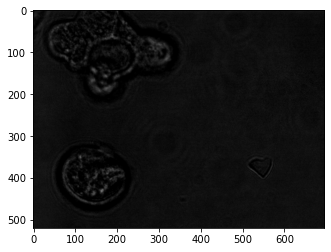

In [228]:
img_display = transform.rescale(img, 0.5)
rr, cc = draw.circle_perimeter(int(row['centroid-0']), int(row['centroid-1']),
                      int(row['equivalent_diameter']/2), shape=img_display.shape)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


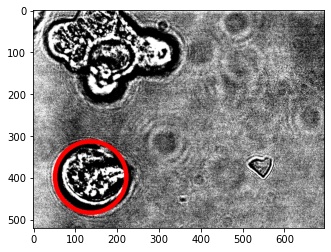

In [284]:
from skimage.color import gray2rgb

# Display our detected images:

img_display = transform.rescale(img, 0.5)
rr, cc = draw.circle_perimeter(int(row['centroid-0']), int(row['centroid-1']),
                      int(row['equivalent_diameter']/2), shape=img_display.shape)
# Normalize the image
im_st = img_display - np.quantile(img_display,0.1)
#Convert to color
rggb = gray2rgb(im_st*1/(np.quantile(im_st,0.95)))
# Get the circle perimeter of the cell
perim = np.zeros(img_display.shape)
perim[rr,cc]=1
perim = morphology.dilation(perim, selem=morphology.disk(5))
plt.imshow(perim)
# Add it to the color image
rggb[perim>0, :] = [1,0,0]
#Display
plt.imshow(rggb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


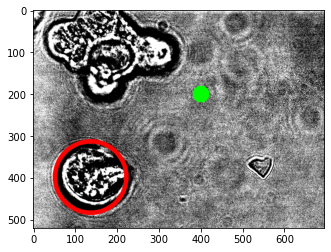

In [285]:
# Get Laser Position Information
move_to = (200,400)
im_size = img_display.shape
# Convert to general fractions of the image (for changing image sizes)
move_to_frac = np.divide(move_to, im_size)
lysis_radius_frac = 20/im_size[0]
# Read back the magic :D 
lysis_yx = np.multiply(move_to_frac, img_display.shape).astype(int)
lysis_radius = int(lysis_radius_frac*img_display.shape[0])
# Get the Circle
rr, cc = draw.circle(lysis_yx[0], lysis_yx[1], lysis_radius)
rggb[rr,cc, :]=[0,1,0]
plt.imshow(rggb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


From: [398, 179] to [200 400] in pixels
Pixel Distance = [-198  221] (y,x)
mm distance = [-198  221] (y,x)


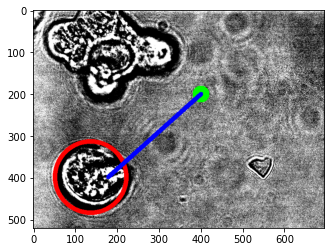

In [286]:
# Draw the Movement Vector
# Get the difference between the coords
cell_yx = [int(row['centroid-0']), int(row['centroid-1'])]
cell_yx[1]+= int(row['equivalent_diameter']/4)
diff_in_pixels = np.subtract(lysis_yx, cell_yx )
# Draw a line
rr,cc = draw.line(cell_yx[0], cell_yx[1], cell_yx[0]+diff_in_pixels[0], cell_yx[1]+diff_in_pixels[1])
perim = np.zeros(img_display.shape)
perim[rr,cc]=1
perim = morphology.dilation(perim, selem=morphology.disk(5))
rggb[perim>0, :] = [0,0,1]
#Scalar to convert to mm
mm_per_pix = [1, 1] * 1 # Change inside the brackets to flip an axis, change outside the axis to change the scalar
diff_in_mm = diff_in_pixels*mm_per_pix
print(f'From: {cell_yx} to {lysis_yx} in pixels')
print(f'Pixel Distance = {diff_in_pixels} (y,x)')
print(f'mm distance = {diff_in_mm} (y,x)')
diff_in_mm
plt.imshow(rggb)

In [261]:
lysis_radius_frac

0.038461538461538464

In [46]:
df

,index,0
0,center,-0000800
1,x,-250120
2,y,349610
3,,-0005800
4,center,-0000800
5,x,-250120
6,y,349610
7,,-0005800


In [47]:
df.pivot(index='index',columns='index', values=0)

ValueError: The name index occurs multiple times, use a level number